In [7]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from dtaidistance import dtw
from scipy.signal import correlate
import pmdarima as pm

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
forex_data_hour = tv.get_hist(symbol='GBPUSD', exchange='ICMARKETS',
                              interval=Interval.in_4_hour, n_bars=4000)

# Display the last five rows
prices = forex_data_hour['close']
prices

ERROR:tvDatafeed.main:error while signin


datetime
2022-04-13 12:00:00    1.29947
2022-04-13 16:00:00    1.30934
2022-04-13 20:00:00    1.31161
2022-04-14 00:00:00    1.31159
2022-04-14 04:00:00    1.31381
                        ...   
2024-11-05 07:00:00    1.29812
2024-11-05 11:00:00    1.29862
2024-11-05 15:00:00    1.30144
2024-11-05 19:00:00    1.30263
2024-11-05 23:00:00    1.30337
Name: close, Length: 4000, dtype: float64

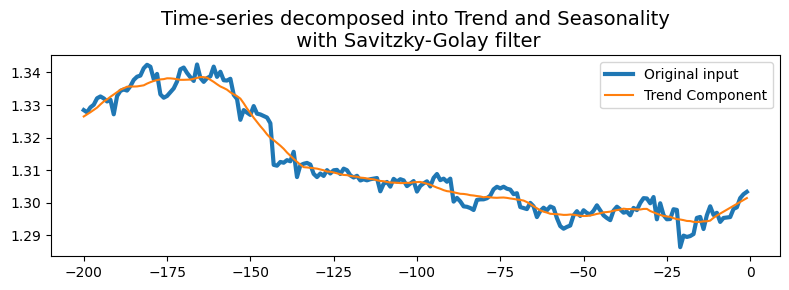

In [8]:
# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

yvalues = prices
yvalues_trend = savgol_filter(yvalues,19,1)
yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-200,0), yvalues[-200:], label='Original input',linewidth=3)
ax.plot(np.arange(-200,0), yvalues_trend[-200:], label='Trend Component')
#ax.plot(yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()


In [9]:
def fft_forecast(signal, forecast_elements, target_harmonics=40):

    # Perform FFT on the seasonal component
    N = len(signal)
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(N)

    # **2. Retain non-negative frequencies (including zero)**
    positive_freq_indices = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_indices]
    fft_result_positive = fft_result[positive_freq_indices]

    # Limit the number of harmonics
    num_harmonics = min(target_harmonics, len(fft_freq_positive))
    frequencies = fft_freq_positive[:num_harmonics]
    amplitudes = fft_result_positive[:num_harmonics]

    # **3. Create extended indices including future points**
    reconstructed_length = N + forecast_elements
    extended_indices = np.arange(reconstructed_length)

    # **4. Reconstruct the signal using the selected harmonics**
    reconstructed_signal = np.zeros(reconstructed_length)

    for i in range(num_harmonics):
        frequency = frequencies[i]
        amplitude_complex = amplitudes[i]
        amplitude = np.abs(amplitude_complex)
        phase = np.angle(amplitude_complex)
        omega = 2 * np.pi * frequency

        if frequency == 0:  # DC component
            reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
        else:
            reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)
    
    return reconstructed_signal, num_harmonics

In [10]:
# Define error metric: Root Mean Squared Error (RMSE)
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [11]:
# Definition of Forecast Parameters
validation_elements = 8
test_elements = 8
seasonal_harmonics_list = np.arange(40, 80, 5)
seasonal_input_elements_list = np.arange(200, 800, 5)
visualization_elements = 120
shift_step = 12
num_runs = 200

# Initialize a list to store results
results = []

for seasonal_harmonics in seasonal_harmonics_list:
    for seasonal_input_elements in seasonal_input_elements_list:
        for run in range(num_runs):
            # Calculate starting index, and get input data slice
            start_idx = len(yvalues_seasonal) - shift_step*run - test_elements - validation_elements - seasonal_input_elements
            input_slice = yvalues_seasonal[start_idx:start_idx+seasonal_input_elements]

            # Generate forecast
            yvalues_seasonal_forecast, num_harmonics = fft_forecast(
                input_slice,
                validation_elements+test_elements,
                seasonal_harmonics
            )
            
            # Convert forecasts to numpy arrays if they're pandas Series
            if isinstance(yvalues_seasonal_forecast, pd.Series):
                yvalues_seasonal_forecast = yvalues_seasonal_forecast.to_numpy()
            if isinstance(yvalues_seasonal, pd.Series):
                yvalues_seasonal = yvalues_seasonal.to_numpy()

            # Extract validation and test portions
            actual_validation = yvalues_seasonal[-validation_elements-test_elements:-test_elements]
            forecast_validation = yvalues_seasonal_forecast[-validation_elements-test_elements:-test_elements]
            actual_test = yvalues_seasonal[-test_elements:]
            forecast_test = yvalues_seasonal_forecast[-test_elements:]

            # Calculate distances
            validation_distance = dtw.distance(actual_validation, forecast_validation)
            test_distance = dtw.distance(actual_test, forecast_test)

            # Calculate cross-correlation for validation set
            validation_cross_corr = correlate(actual_validation, 
                                              forecast_validation, 
                                              mode='full')
            validation_max_corr = max(validation_cross_corr)
            
            # Calculate cross-correlation for test set
            test_cross_corr = correlate(actual_test, 
                                        forecast_test, 
                                        mode='full')
            test_max_corr = max(test_cross_corr)

            # Store the results
            results.append({
                'seasonal_input_length': seasonal_input_elements,
                'seasonal_harmonics': seasonal_harmonics,
                'run': run,
                'rmse_validation': calculate_rmse(actual_validation, forecast_validation),
                'rmse_test': calculate_rmse(actual_test, forecast_test),
                'dtw_validation': validation_distance,
                'dtw_test': test_distance,
                'cc_validation': validation_max_corr,
                'cc_test': test_max_corr
            })

# Create DataFrame and calculate statistics only if we have results
if results:
    results_df = pd.DataFrame(results)
    print("\nSummary Statistics:")
    print("Mean of RMSE Validation:", results_df['rmse_validation'].mean())
    print("Mean of RMSE Test:", results_df['rmse_test'].mean())
    print("R-squared between RMSE Validation and RMSE Test:", 
          r2_score(results_df['rmse_validation'], results_df['rmse_test']))
    print("Pearson Correlation:", 
          results_df['rmse_validation'].corr(results_df['rmse_test']))
    print("R-squared between Validation and Test (DTW Distance):", 
          r2_score(results_df['dtw_validation'], results_df['dtw_test']))
    print("Pearson Correlation (DTW Distance):", 
          results_df['dtw_validation'].corr(results_df['dtw_test']))
    print("R-squared between Validation and Test (Cross-correlation):", 
          r2_score(results_df['cc_validation'], results_df['cc_test']))
    print("Pearson Correlation (Cross-correlation):", 
          results_df['cc_validation'].corr(results_df['cc_test']))
else:
    print("No valid results were generated.")


Summary Statistics:
Mean of RMSE Validation: 0.0032075294089187376
Mean of RMSE Test: 0.00291201410815684
R-squared between RMSE Validation and RMSE Test: -0.7907254240273653
Pearson Correlation: 0.4129788508425866
R-squared between Validation and Test (DTW Distance): -1.4595811850801126
Pearson Correlation (DTW Distance): 0.4657403615561961
R-squared between Validation and Test (Cross-correlation): -0.6620635758351983
Pearson Correlation (Cross-correlation): 0.41134010529693377


In [12]:
results_df.describe()

,seasonal_input_length,seasonal_harmonics,run,rmse_validation,rmse_test,dtw_validation,dtw_test,cc_validation,cc_test
count,192000.000000,192000.000000,192000.000000,192000.000000,192000.000000,192000.000000,192000.000000,1.920000e+05,1.920000e+05
mean,497.500000,57.500000,99.500000,0.003208,0.002912,0.007290,0.007081,1.459028e-05,2.039911e-05
std,173.199518,11.456469,57.734456,0.001061,0.001436,0.002331,0.004096,1.171500e-05,1.378216e-05
min,200.000000,40.000000,0.000000,0.001236,0.000400,0.001252,0.000857,1.452143e-07,2.916319e-07
25%,348.750000,48.750000,49.750000,0.002441,0.001869,0.005787,0.004052,6.154773e-06,1.043928e-05
50%,497.500000,57.500000,99.500000,0.002946,0.002658,0.006697,0.006192,1.102159e-05,1.733832e-05
75%,646.250000,66.250000,149.250000,0.003694,0.003650,0.008098,0.009203,1.948820e-05,2.687020e-05
max,795.000000,75.000000,199.000000,0.013772,0.012447,0.033587,0.035204,8.568805e-05,1.637669e-04


In [13]:
results_df[results_df['run']==1].sort_values(by='dtw_validation', ascending=True).head(40)

,seasonal_input_length,seasonal_harmonics,run,rmse_validation,rmse_test,dtw_validation,dtw_test,cc_validation,cc_test
144601,215,70,1,0.002623,0.001790,0.003475,0.004317,0.000028,0.000050
96601,215,60,1,0.002593,0.001776,0.003698,0.004365,0.000027,0.000051
168601,215,75,1,0.002653,0.001764,0.003727,0.004276,0.000028,0.000050
120601,215,65,1,0.002588,0.001762,0.003788,0.004315,0.000027,0.000051
148401,310,70,1,0.001973,0.001740,0.004216,0.001824,0.000010,0.000019
72601,215,55,1,0.002577,0.001716,0.004261,0.004198,0.000026,0.000050
100401,310,60,1,0.001844,0.001715,0.004266,0.001729,0.000012,0.000019
176401,410,75,1,0.001519,0.002395,0.004295,0.004744,0.000015,0.000010
28001,300,45,1,0.001544,0.001467,0.004326,0.003648,0.000019,0.000043
170801,270,75,1,0.002081,0.003064,0.004358,0.007410,0.000012,0.000016


/var/folders/t7/qhsh0qws38d4057943350r400000gn/T/ipykernel_94943/77976689.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correct_count = results_df.groupby(['dtw_bin', 'cc_bin'])['correct_prediction'].sum().unstack()
/var/folders/t7/qhsh0qws38d4057943350r400000gn/T/ipykernel_94943/77976689.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_count = results_df.groupby(['dtw_bin', 'cc_bin'])['correct_prediction'].count().unstack()
/var/folders/t7/qhsh0qws38d4057943350r400000gn/T/ipykernel_94943/77976689.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot

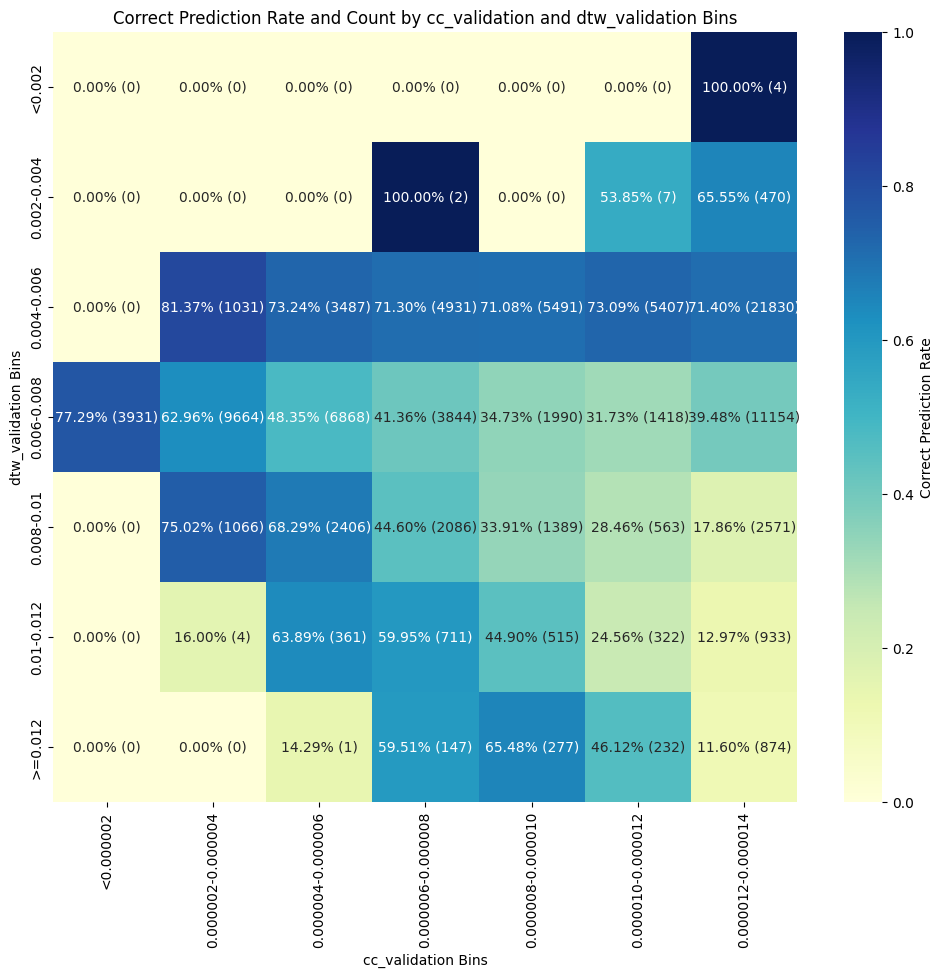

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `results_df` is your DataFrame with 'cc_validation', 'dtw_validation', and 'rmse_test' columns

# Parameters to control the bins
cc_bins_start = 0.000002
cc_bins_interval = 0.000002
cc_bins_last = 0.000012
cc_bins = [0] + list(np.arange(cc_bins_start, cc_bins_last + cc_bins_interval, cc_bins_interval)) + [float('inf')]
cc_labels = [f"<{cc_bins_start:.6f}"] + [
    f"{i:.6f}-{(i + cc_bins_interval):.6f}" for i in np.arange(cc_bins_start, cc_bins_last, cc_bins_interval)
] + [f">={cc_bins_last:.6f}"]

# Parameters to control the dtw bins
dtw_bins_start = 0.002
dtw_bins_interval = 0.002
dtw_bins_last = 0.012
dtw_bins = [0] + list(np.arange(dtw_bins_start, dtw_bins_last + dtw_bins_interval, dtw_bins_interval)) + [float('inf')]
dtw_labels = [f"<{dtw_bins_start}"] + [f"{i}-{i + dtw_bins_interval}" for i in np.arange(dtw_bins_start, dtw_bins_last, dtw_bins_interval)] + [f">={dtw_bins_last}"]

# Ensure labels are one less than bins
if len(cc_labels) != len(cc_bins) - 1:
    cc_labels = cc_labels[:len(cc_bins) - 1]


# Add a column to indicate whether the prediction is correct based on `rmse_test < 3`
results_df['correct_prediction'] = results_df['rmse_test'] < 0.002658

# Bin the `cc_validation` and `dtw_validation` values
results_df['cc_bin'] = pd.cut(results_df['cc_validation'], bins=cc_bins, labels=cc_labels, right=False)
results_df['dtw_bin'] = pd.cut(results_df['dtw_validation'], bins=dtw_bins, labels=dtw_labels, right=False)

# Calculate the rate and count of correct predictions for each combination of `cc_bin` and `dtw_bin`
correct_count = results_df.groupby(['dtw_bin', 'cc_bin'])['correct_prediction'].sum().unstack()
total_count = results_df.groupby(['dtw_bin', 'cc_bin'])['correct_prediction'].count().unstack()
correct_rate = (correct_count / total_count).fillna(0)

# Create annotation text with rate and count in each cell
annot = correct_rate.applymap(lambda x: f"{x:.2%}") + correct_count.applymap(lambda x: f" ({int(x)})")

# Plot the heatmap with custom annotations
plt.figure(figsize=(12, 10))
sns.heatmap(correct_rate, annot=annot, fmt='', cmap='YlGnBu', cbar_kws={'label': 'Correct Prediction Rate'})
plt.xlabel('cc_validation Bins')
plt.ylabel('dtw_validation Bins')
plt.title('Correct Prediction Rate and Count by cc_validation and dtw_validation Bins')
plt.show()

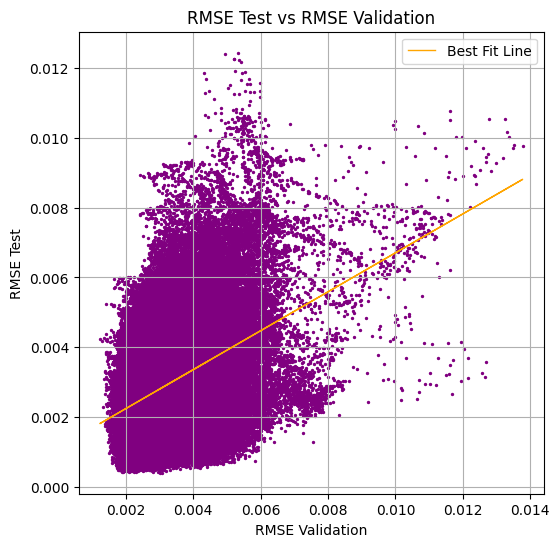

In [15]:
# Scatter plot of RMSE Test against RMSE Validation with smaller dots
plt.figure(figsize=(6, 6))
plt.scatter(results_df['rmse_validation'], results_df['rmse_test'], color='purple', s=2)

# Calculate the best-fit line using numpy's polyfit function
m, b = np.polyfit(results_df['rmse_validation'], results_df['rmse_test'], 1)  # 1st-degree polynomial for linear fit

# Plot the regression line
plt.plot(results_df['rmse_validation'], m * results_df['rmse_validation'] + b, color='orange', linewidth=1, label='Best Fit Line')

# Adding labels, title, and legend
plt.xlabel('RMSE Validation')
plt.ylabel('RMSE Test')
plt.title('RMSE Test vs RMSE Validation')
plt.legend()
plt.grid(True)
plt.show()

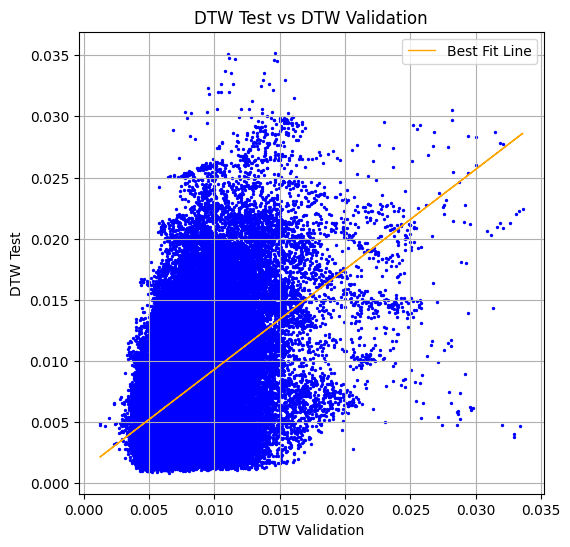

In [16]:
# Scatter plot of DTW Test distance against DTW Validation distance with smaller dots
plt.figure(figsize=(6, 6))
plt.scatter(results_df['dtw_validation'], results_df['dtw_test'], color='blue', s=2)

# Calculate the best-fit line using numpy's polyfit function
m, b = np.polyfit(results_df['dtw_validation'], results_df['dtw_test'], 1)  # 1st-degree polynomial for linear fit

# Plot the regression line
plt.plot(results_df['dtw_validation'], m * results_df['dtw_validation'] + b, color='orange', linewidth=1, label='Best Fit Line')

# Adding labels, title, and legend
plt.xlabel('DTW Validation')
plt.ylabel('DTW Test')
plt.title('DTW Test vs DTW Validation')
plt.legend()
plt.grid(True)
plt.show()

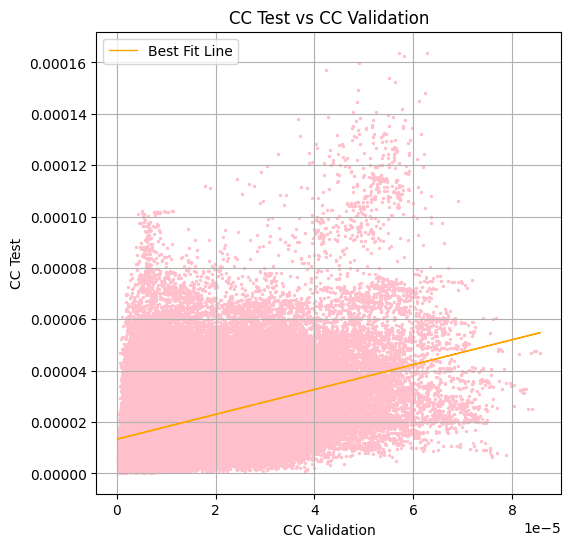

In [17]:
# Scatter plot of CC Test distance against CC Validation distance with smaller dots
plt.figure(figsize=(6, 6))
plt.scatter(results_df['cc_validation'], results_df['cc_test'], color='pink', s=2)

# Calculate the best-fit line using numpy's polyfit function
m, b = np.polyfit(results_df['cc_validation'], results_df['cc_test'], 1)  # 1st-degree polynomial for linear fit

# Plot the regression line
plt.plot(results_df['cc_validation'], m * results_df['cc_validation'] + b, color='orange', linewidth=1, label='Best Fit Line')

# Adding labels, title, and legend
plt.xlabel('CC Validation')
plt.ylabel('CC Test')
plt.title('CC Test vs CC Validation')
plt.legend()
plt.grid(True)
plt.show()

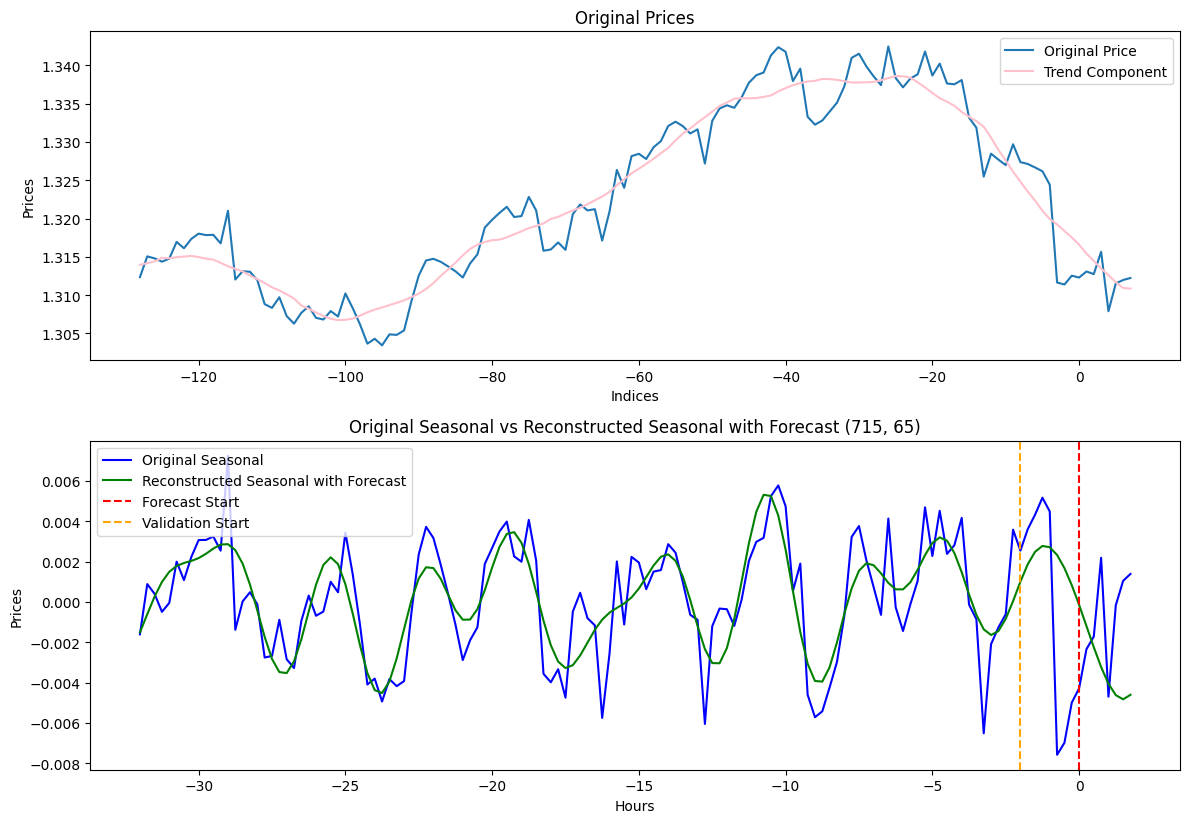

In [18]:
# Plotting for a specific run
seasonal_input_elements = 715
seasonal_harmonics = 65
run = 11

start_idx = len(yvalues_seasonal) - shift_step*run - test_elements - validation_elements - seasonal_input_elements
yvalues_seasonal_forecast, num_harmonics = fft_forecast( yvalues_seasonal[start_idx:start_idx+seasonal_input_elements],
                                                        validation_elements+test_elements,
                                                        seasonal_harmonics )

# Calculate slice indices
len_slice = visualization_elements + validation_elements + test_elements
slice_start_idx = -(shift_step * run + len_slice)
slice_end_idx = -shift_step * run
slice_idx_list = np.arange(-len_slice+test_elements, test_elements)

# Define a helper function for slicing with the condition
def safe_slice(data, start_idx, end_idx):
    return data[start_idx:] if end_idx == 0 else data[start_idx:end_idx]

# Apply the helper function to each slice
prices_slice = safe_slice(prices, slice_start_idx, slice_end_idx)
yvalues_trend_slice = safe_slice(yvalues_trend, slice_start_idx, slice_end_idx)
seasonal_original_slice = safe_slice(yvalues_seasonal, slice_start_idx, slice_end_idx)
seasonal_forecast_slice = yvalues_seasonal_forecast[-len_slice:]



# **6b. Plotting**
plt.figure(figsize=(12, 12))

# Plot original price and trend
plt.subplot(3, 1, 1)
plt.plot(slice_idx_list, prices_slice, label="Original Price")
plt.plot(slice_idx_list, yvalues_trend_slice, label='Trend Component', color='pink')
plt.title("Original Prices")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

# Plot original and reconstructed seasonal
plt.subplot(3, 1, 2)
plt.plot(slice_idx_list/4, seasonal_original_slice, label="Original Seasonal", color='blue')
plt.plot(slice_idx_list/4, seasonal_forecast_slice, label="Reconstructed Seasonal with Forecast", color='green')
plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
plt.axvline(x=-validation_elements/4, color='orange', linestyle='--', label="Validation Start")
plt.title(f"Original Seasonal vs Reconstructed Seasonal with Forecast ({seasonal_input_elements}, {seasonal_harmonics})")
plt.xlabel("Hours")
plt.ylabel("Prices")
plt.legend()

plt.tight_layout()
plt.show()